# STATE OF THE STATE ADDRESSES, TOPICS, AND POLITICAL PARTY TRENDS
## Questions of interest:
### 1) Are there any common themes, policies, or topics that are addressed by many or all states?
### 2) Are there discrepancies in policy and protocol found in "State of the State" addresses that are connected to the governors' political affliation?

In [501]:
import pandas as pd
import matplotlib.pyplot as plt

# Read in the data.

In [459]:
# Import the data
gov = pd.read_csv('gov.csv', header = 0, sep = ",")
gov.head()

,State,Governor,Party,Speech
0,Alabama,Kay Ivey,Republican,"Lieutenant Governor Ainsworth, Pro Tempore Mar..."
1,Alabama,Kay Ivey,Republican,"Just over 48 hours ago, Mother Nature’s wrath ..."
2,Alabama,Kay Ivey,Republican,At least 23 innocent lives were lost.
3,Alabama,Kay Ivey,Republican,Young children who had barely experienced life.
4,Alabama,Kay Ivey,Republican,Mothers. Fathers. Friends and neighbors.


In [460]:
# View the shape of dataframe
gov.shape

(6052, 4)

In [461]:
# View the demographics of the data
gov['Party'].value_counts()

Republican    3383
Democrat      2669
Name: Party, dtype: int64

# Clean the speech text.

In [462]:
# Check for missing values in 'label' variable
print(sum(gov['Party'].isnull()))
# No missing values to account for.

# Check for missing values in 'review' variable
print(sum(gov['Speech'].isnull()))
# No missing values to account for.

0
0


In [463]:
# Filter dataset to use only "Speech" column for text editing
speech = gov.copy()
speech = speech['Speech']

In [464]:
# Lowercase all words
speech = speech.str.lower()

In [465]:
# Remove puncutation:
# Quotation Marks
speech = speech.apply(lambda x: x.replace("'", ""))
# Question Marks
speech = speech.apply(lambda x: x.replace("?", ""))
# Colons
speech = speech.apply(lambda x: x.replace(":", ""))
# Semicolons
speech = speech.apply(lambda x: x.replace(";", ""))
# Commas
speech = speech.apply(lambda x: x.replace(",", ""))
# Periods
speech = speech.apply(lambda x: x.replace(".", ""))

In [466]:
# Add cleaned text to a new copy of "gov" dataset
state = gov.copy()
state["Text"] = speech
# Filter dataset to use only "Party" and "Text" columns for text analysis
state = state[["Party", "Text"]]
state.head()

,Party,Text
0,Republican,lieutenant governor ainsworth pro tempore mars...
1,Republican,just over 48 hours ago mother nature’s wrath –...
2,Republican,at least 23 innocent lives were lost
3,Republican,young children who had barely experienced life
4,Republican,mothers fathers friends and neighbors


In [467]:
# Demographics of final dataset
print(len(state[state.Party == "Republican"]))
print(len(state[state.Party == "Democrat"]))

3383
2669


In [468]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jwoff\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [469]:
# Remove stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(["us", "state", "new", "then", "them", "make", "every", "people", "we", "one", "year", "years", "work", "also", "way", "great", "time", "know", "re", "ve", "thats", "ever", "everyone", "today", "must", "want", "get", "need", "we", "together", "let", "like", "many", "it", "going"])
state['Text'] = state['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Most common words (that aren't stopwords) from the speeches:

In [470]:
# Create function using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(text, n=None):
    vec = CountVectorizer().fit(text)
    all_words = vec.transform(text)
    sum_words = all_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [471]:
# Most Common Words generally
common = get_top_n_words(state["Text"], 15)
for word, freq in common:
    print(word, freq)

education 441
we 393
school 387
first 361
health 359
budget 354
million 337
help 325
tax 325
last 324
working 319
students 305
it 298
care 283
jobs 282


In [472]:
# Republican Most Common Words
rep = state[state.Party == "Republican"]
common_r = get_top_n_words(rep["Text"], 20)
for word, freq in common_r:
    print(word, freq)

education 255
school 245
million 230
last 197
tax 197
first 196
help 187
budget 178
students 164
we 161
south 158
government 156
working 152
would 149
health 147
public 146
better 144
it 141
system 138
business 135


In [473]:
# Democrat Most Common Words
dem = state[state.Party == "Democrat"]
common_d = get_top_n_words(dem["Text"], 20)
for word, freq in common_d:
    print(word, freq)

we 232
health 212
education 186
care 180
budget 176
working 167
first 165
families 165
jobs 160
it 157
good 148
school 142
students 141
help 138
children 138
re 135
ve 132
economy 129
tax 128
last 127


# Perform a kmeans clustering on the text of the speeches.

In [474]:
# Use TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer()
X = tf.fit_transform(state["Text"])

### How many clusters best summarizes the data?

In [475]:
from sklearn.cluster import KMeans
wcss = []
for k in range(5,51,5):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

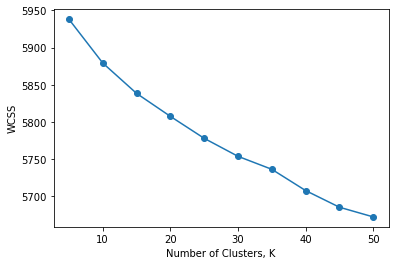

In [476]:
plt.plot(np.arange(5,51,5),wcss,marker="o")
plt.xlabel('Number of Clusters, K')
plt.ylabel('WCSS')

### The most notable bend occurs at 30 clusters. Use k = 30.

In [477]:
km = KMeans(30)
km.fit(X)
labs = kmeans.predict(X)

In [478]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20)
comps = svd.fit_transform(X)

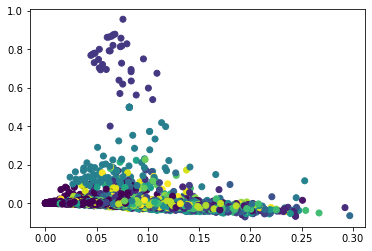

In [479]:
plt.scatter(comps[:,0], comps[:,1], c=kmeans.labels_)

##### It is a lot harder to tell how much seperation there is when using 30 clusters, but given that there were two clusters that were notably distinct from the rest of the points in the scatterplot, I trust the data to say the seperation between the clusters is good enough to move forward.

### Interpret the clusters based on the top words of each cluster.

In [480]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tf.get_feature_names()
for i in range(30):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: first last two public states right day law come history
Cluster 1: would said told create got tell less day good working
Cluster 2: million dollars budget additional funding investment fund includes increase 100
Cluster 3: jobs economy growth economic good development paying clean energy create
Cluster 4: better future lives place even families working believe elected opportunities
Cluster 5: education higher system public funding students quality opportunity early budget
Cluster 6: ve we done got seen it made better successful success
Cluster 7: mr members speaker president fellow guests distinguished chief justice assembly
Cluster 8: bless god thank may america united states continue commonwealth lets
Cluster 9: care health costs access affordable medicaid hospitals provide system needs
Cluster 10: help can families nebraska crisis grow please opportunity successes team
Cluster 11: see already right working law would opportunity that something last
Cluster 12: future gener

##### From these clusters, I identified seven different "themes" to group these clusters into (the theme itself is capitalized).
##### The largest group of clusters talked about the WORKFORCE, such as creating job opportunities, supporting small businesses, and improving the economy (found in Clusters 1, 3, 12, 18, 19, 23, and 29). 
##### EDUCATION was the next most popular theme, including mentions about teacher pay, higher education funding, and other beneficial services for children with concerns like mental health and addiction (found in Clusters 5, 14, 15, 17, and 26).
##### Another common theme was about HEALTHCARE, including making it affordable and providing appropriate services (found in Clusters 9 and 26). 
##### I was a little surprised that the BUDGET and FINANCIAL-related matters didn't get more attention from the clusters, as only Cluster 2 seemed to mention it. 
##### I did not expect to see so many clusters talk about QUALITY OF LIVING, including public safety, individual rights, and second-chance policies (found in Clusters 0, 4, 11, 13, 22, 24, and 25).
##### It was refreshing to see that the FAMILY UNIT had a couple clusters, mentioning about topics such as foster care and child support (found in Clusters 10 and 20). 
##### The last theme was more fluffy, feel-good ACKNOWLEDGEMENTS, such as recognizing distinguished officials, providing optimism for the future, and hopes of God blessing America (found in Clusters 6, 7, 8, 16, 21, 27, and 28).

# Build a model that uses the speech text to classify which political party the speech came from.

In [481]:
from sklearn.model_selection import train_test_split
# Create the training and testings sets. Use test_size = 0.4 and random_state = 713.
train, test = train_test_split(state, test_size = 0.4, stratify = state.Party, random_state = 713)

In [482]:
# View the shapes of training and testing sets.
print("Train:", train.shape)
print("Test:", test.shape)

Train: (3631, 2)
Test: (2421, 2)


In [483]:
# View the testing set
test.head()

,Party,Text
3025,Republican,however …
2569,Republican,next 90 days army operators tradespeople first...
5083,Republican,cost business imposed heavy-handed special int...
4098,Republican,never competitive dont keep paying attention r...
691,Democrat,look easy would done already progress always h...


In [484]:
# View demographics of training and testing sets
y_train = (train['Party'] == 'Republican').astype(int)
y_test = (test['Party'] == 'Republican').astype(int)
print(1-y_train.mean())
print(y_test.mean())

0.4409253649132471
0.5588599752168525


In [485]:
# To keep the X matrix from being too large, use min_df = 50.
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 50)

In [486]:
# Be sure that all model development is with the training data
tfidf.fit(train['Text'])
X_train = tfidf.transform(train['Text'])
X_test = tfidf.transform(test['Text'])

### Using the default tuning parameter values, fit models using Multinomial Naive Bayes, Decision Tree, Random Forest, and Gradient Boosting.

In [487]:
# Build classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [488]:
# Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
yhat_nb = nb.predict(X_test)
y_nb_prob = nb.predict_proba(X_test)[:,1]

In [489]:
# Decision Tree
dtr = DecisionTreeClassifier()
dtr.fit(X_train, y_train)
yhat_dtr = dtr.predict(X_test)
y_dtr_prob = dtr.predict_proba(X_test)[:,1]

In [490]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
yhat_rf = rf.predict(X_test)
y_rf_prob = rf.predict_proba(X_test)[:,1]

In [491]:
# Gradient Boosting
grb = GradientBoostingClassifier()
grb.fit(X_train, y_train)
yhat_grb = grb.predict(X_test)
y_grb_prob = grb.predict_proba(X_test)[:,1]

### What model performs the best?

In [492]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score

In [493]:
# Create plot_roc_curve function to generate ROC curve.
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

[[ 367  701]
 [ 255 1098]]
 
Accuracy:  0.6051218504750103
F1 Score:  0.6967005076142132
Precision: 0.6103390772651474
Recall:    0.811529933481153
AUC:       0.6396411359414922


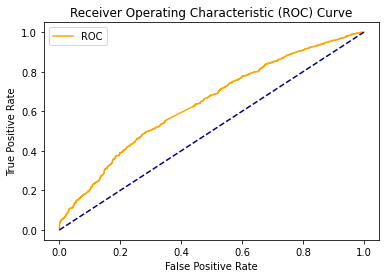

In [494]:
# Multinomial Naive Bayes Metrics
print(confusion_matrix(y_test, yhat_nb))
print(" ")
print("Accuracy: ", accuracy_score(y_test, yhat_nb))
print("F1 Score: ", f1_score(y_test, yhat_nb))
print("Precision:", precision_score(y_test, yhat_nb))
print("Recall:   ", recall_score(y_test, yhat_nb))
print("AUC:      ", roc_auc_score(y_test, y_nb_prob))

fpr, tpr, thresh = roc_curve(y_test, y_nb_prob)
plot_roc_curve(fpr, tpr)

[[509 559]
 [526 827]]

Accuracy:  0.5518380834365965
F1 Score:  0.6038700255567725
Precision: 0.5966810966810967
Recall:    0.6112342941611234
AUC:       0.5619081331262751


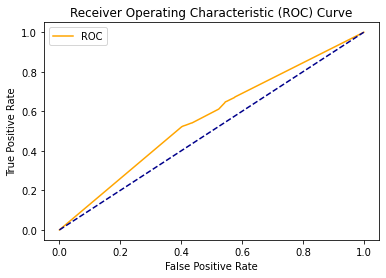

In [495]:
# Decision Tree Metrics
print(confusion_matrix(y_test, yhat_dtr))
print("")
print("Accuracy: ", accuracy_score(y_test, yhat_dtr))
print("F1 Score: ", f1_score(y_test, yhat_dtr))
print("Precision:", precision_score(y_test, yhat_dtr))
print("Recall:   ", recall_score(y_test, yhat_dtr))
print("AUC:      ", roc_auc_score(y_test, y_dtr_prob))

fpr, tpr, thresh = roc_curve(y_test, y_dtr_prob)
plot_roc_curve(fpr, tpr)

[[487 581]
 [436 917]]
 
Accuracy:  0.5799256505576208
F1 Score:  0.6432830585759383
Precision: 0.6121495327102804
Recall:    0.6777531411677753
AUC:       0.6069564513316226


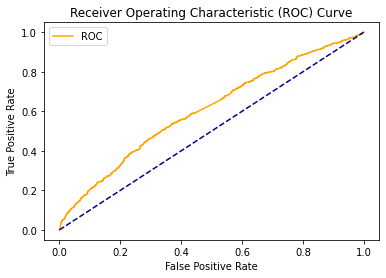

In [496]:
# Random Forest Metrics
print(confusion_matrix(y_test, yhat_rf))
print(" ")
print("Accuracy: ", accuracy_score(y_test, yhat_rf))
print("F1 Score: ", f1_score(y_test, yhat_rf))
print("Precision:", precision_score(y_test, yhat_rf))
print("Recall:   ", recall_score(y_test, yhat_rf))
print("AUC:      ", roc_auc_score(y_test, y_rf_prob))

fpr, tpr, thresh = roc_curve(y_test, y_rf_prob)
plot_roc_curve(fpr, tpr)

[[ 320  748]
 [ 215 1138]]
 
Accuracy:  0.6022304832713755
F1 Score:  0.7026860142019141
Precision: 0.6033934252386002
Recall:    0.8410938654841094
AUC:       0.6252823521595788


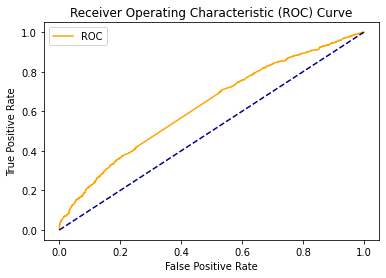

In [497]:
# Gradient Boosting Metrics
print(confusion_matrix(y_test, yhat_grb))
print(" ")
print("Accuracy: ", accuracy_score(y_test, yhat_grb))
print("F1 Score: ", f1_score(y_test, yhat_grb))
print("Precision:", precision_score(y_test, yhat_grb))
print("Recall:   ", recall_score(y_test, yhat_grb))
print("AUC:      ", roc_auc_score(y_test, y_grb_prob))

fpr, tpr, thresh = roc_curve(y_test, y_grb_prob)
plot_roc_curve(fpr, tpr)

### I felt it was best to use the Multinomial Naive Bayes model.
##### The following are the metrics from this model: Accuracy = 0.6051, F1 Score = 0.6967, Precision = 0.6103, Recall = 0.8115, AUC = 0.6396

### Compare potential important features between the two political parties for the Multinomial Naive Bayes model.

In [498]:
# Create 'importance' dataframe for Multinomial Naive Bayes model
importance_nb = pd.DataFrame()
importance_nb['words'] = tfidf.get_feature_names()
# Convert log probabilities to probabilities. 
importance_nb['Importance_Dem'] = np.e**(nb.feature_log_prob_[0, :])
importance_nb['Importance_Rep'] = np.e**(nb.feature_log_prob_[1, :])
importance_nb.set_index('words', inplace=True)

In [499]:
# Find important words specifically for Democrat speeches
print(importance_nb["Importance_Rep"].sort_values(ascending = False)[len(importance_nb["Importance_Rep"])-20:,])

words
expand      0.003434
programs    0.003433
real        0.003412
means       0.003367
progress    0.003357
already     0.003353
college     0.003216
young       0.003203
rural       0.003198
water       0.003149
lead        0.003140
raise       0.002868
end         0.002847
don         0.002749
ll          0.002748
child       0.002723
cost        0.002653
small       0.002578
sure        0.002389
start       0.001995
Name: Importance_Rep, dtype: float64


In [500]:
# Find words important specifically for Republican speeches
print(importance_nb["Importance_Dem"].sort_values(ascending = False)[len(importance_nb["Importance_Dem"])-20:,])

words
local             0.003278
fund              0.003255
expand            0.003216
percent           0.003203
hope              0.003202
opportunities     0.003187
administration    0.003173
investment        0.003164
got               0.003060
department        0.002920
growth            0.002909
another           0.002875
plan              0.002735
protect           0.002718
worked            0.002646
rate              0.002597
tell              0.002026
second            0.001705
south             0.000665
dakota            0.000320
Name: Importance_Dem, dtype: float64


##### One potential connection in the "important" Democrat list comes from the words "child", "raise", "young", and "college". There might be the occasional instance that "programs" applies to this as well. I don't think this directly correlates to the KMeans cluster theme of education, but it seems like Democratic governors have more interest about the future citizens of their states. 
##### Republican governors seem more likely to use words such as "rate", "growth", "expand", and "investment". It is harder to pinpoint these words to any one theme, but these words likely indicate a deeper focus on the trajectory and speed of the productivity and prosperity of the state. In other words, they care about how things are going now. 
### Based on these features, while there were no notable differences in the actual policies spoken of, there does seem to be a distinction in the emphasized timeframe. Democrats seem more likely to focus on the future, while Republicans prioritize the present.